<a href="https://colab.research.google.com/github/kafu77/Capestone_Project_Udemy/blob/main/Comparing_classification_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Data reading and visaulizing tools
import numpy as np
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

#preprocessing tools
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.tree import export_text, plot_tree,export_graphviz

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#models performance evaulation tools
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

#additional tools
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel

from sklearn import set_config
set_config(display='diagram')

In [ ]:
drug=pd.read_csv('/content/drive/MyDrive/SVM/drug200.csv')
drug.head(10)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
5,22,F,NORMAL,HIGH,8.607,drugX
6,49,F,NORMAL,HIGH,16.275,DrugY
7,41,M,LOW,HIGH,11.037,drugC
8,60,M,NORMAL,HIGH,15.171,DrugY
9,43,M,LOW,NORMAL,19.368,DrugY


In [ ]:
drug.shape

(200, 6)

In [ ]:
math.sqrt(200)

14.142135623730951

In [ ]:
drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
drug.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [ ]:
drug['Drug'].unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

In [ ]:
sum(drug['Drug']=='DrugY'),sum(drug['Drug']=='drugC'),sum(drug['Drug']=='drugX'),sum(drug['Drug']=='drugA'),sum(drug['Drug']=='drugB')

(91, 16, 54, 23, 16)

Our classification datas are imbalanced, the accurcy score is not important

In [ ]:
drug['BP'].unique()

array(['HIGH', 'LOW', 'NORMAL'], dtype=object)

In [ ]:
drug['Cholesterol'].unique()

array(['HIGH', 'NORMAL'], dtype=object)

In [ ]:
drug['Sex'].unique()

array(['F', 'M'], dtype=object)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


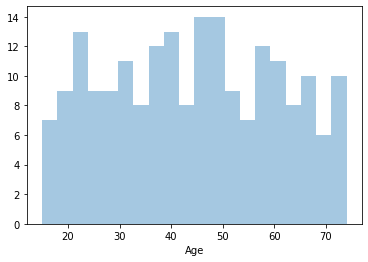

In [ ]:
sns.distplot(drug['Age'], bins=20, kde=False)

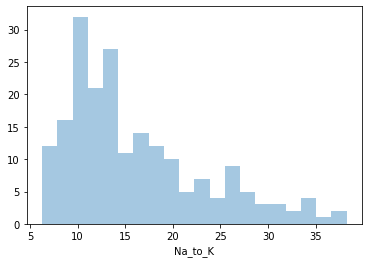

In [ ]:
sns.distplot(drug['Na_to_K'], bins=20, kde=False)

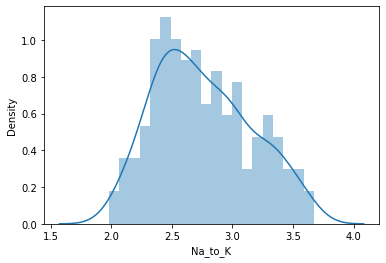

In [ ]:
sns.distplot(np.log1p(drug['Na_to_K']), bins=20, kde=True)


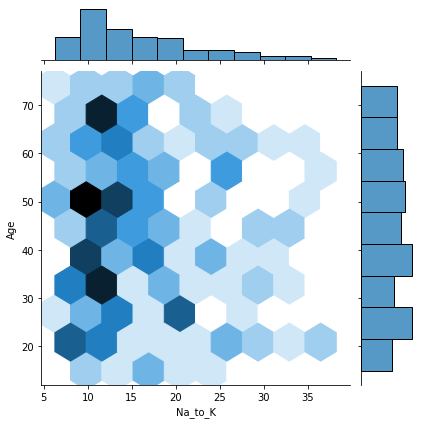

In [ ]:
sns.jointplot(data=drug,x='Na_to_K',y='Age', kind='hex')

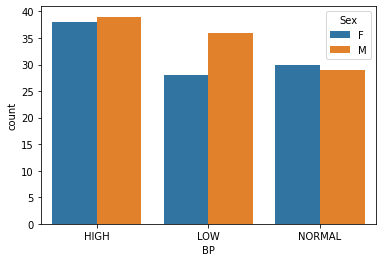

In [ ]:
sns.countplot(data=drug,x='BP',hue='Sex')

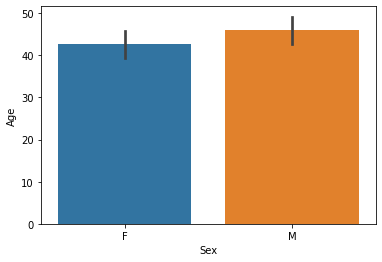

In [ ]:
sns.barplot(data=drug,x='Sex',y='Age')

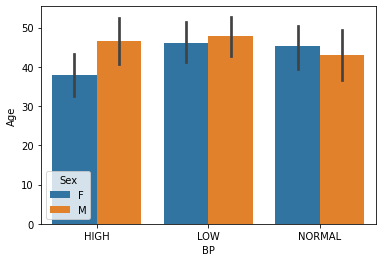

In [ ]:
sns.barplot(data=drug,x='BP',y='Age', hue='Sex')

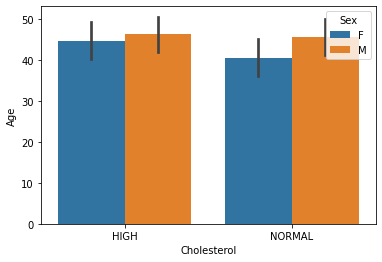

In [ ]:
sns.barplot(data=drug,x='Cholesterol',y='Age', hue='Sex')

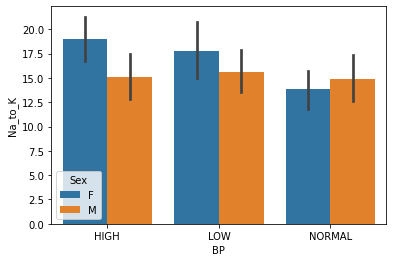

In [ ]:
sns.barplot(data=drug,x='BP',y='Na_to_K', hue='Sex')

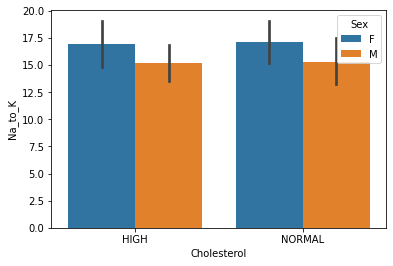

In [ ]:
sns.barplot(data=drug,x='Cholesterol',y='Na_to_K', hue='Sex')

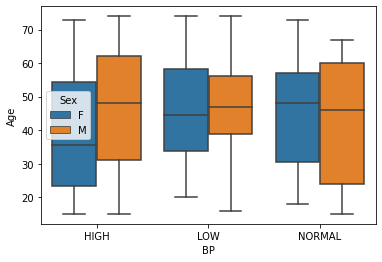

In [ ]:
sns.boxplot(data=drug,x ='BP',y='Age',hue='Sex')

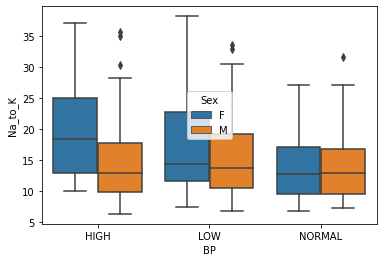

In [ ]:
sns.boxplot(data=drug,x ='BP',y='Na_to_K',hue='Sex')

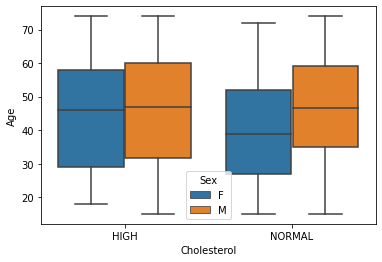

In [ ]:
sns.boxplot(data=drug,x ='Cholesterol',y='Age',hue='Sex')

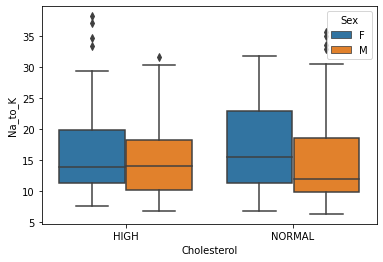

In [ ]:
sns.boxplot(data=drug,x ='Cholesterol',y='Na_to_K',hue='Sex')

In [ ]:
#check missing values
drug.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

### Prepare the data

In [ ]:
X=drug.drop('Drug',axis=1)
y=drug['Drug']

###  Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Transformers

In [ ]:
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['Sex']),
                                     (OrdinalEncoder(categories = [['LOW', 'NORMAL', 'HIGH']]), ['BP']),
                                      (OrdinalEncoder(categories=[[ 'NORMAL','HIGH']]),['Cholesterol']),
                                      remainder=StandardScaler())
extractor = SelectFromModel(LogisticRegression(penalty='l2', solver ='lbfgs' ,random_state = 42, multi_class='multinomial'))

### Create pipelines

In [ ]:
#K nearst neibour pipelines
knn_pipe=Pipeline(
    steps=[('transformer',transformer),
          ('knn', KNeighborsClassifier())]
)

#Decision tree pipelines
dtree_pipe=Pipeline(
    steps=[('transformer',transformer),
           ('dtree',DecisionTreeClassifier())]
)


#logestic regression pipelines 
lgr_pipe=Pipeline(
    steps=[('transformer',transformer),
           ('selector',extractor),
           ('lrg',LogisticRegression())]
)

#Support Vector Machine pipelines
svc_pipe=Pipeline(
    steps=[('transformer',transformer),
           ('svc',SVC())]
)

### Tunning hyperparameters

In [ ]:
#K nearst neibour hyperparamers dictionary
knn_params={'knn__n_neighbors':range(1,16,2),
        'knn__weights':['uniform','distance'],
        'knn__p':[1,2]}


#Decision tree hyperparamers dictionary
dtree_params = {'dtree__max_depth':[2,4,6],
                'dtree__min_samples_split':[0.1, 0.2, 0.05],
                'dtree__criterion': ['gini','entropy'],
                'dtree__min_samples_leaf':[1,2,3]
         }

#Support vector machine hyperparamers dictionary
svc_params= {'svc__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
              'svc__gamma': [0.1, 1.0, 10.0, 100.0],
              'svc__coef0':[0,1,2,3],
              'svc__degree':[2,3,4,5]}

#GridSearchCV of all models

In [ ]:
# K Nearst neighbor gridsearch
%%time
knn_grid=GridSearchCV(estimator=knn_pipe,
                      param_grid=knn_params,
                     cv=5)
knn=knn_grid.fit(X_train,y_train)

CPU times: user 2.78 s, sys: 32.2 ms, total: 2.81 s
Wall time: 2.88 s


In [ ]:
knn.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['LOW',
                                                                              'NORMAL',
                                                                              'HIGH']]),
                                                  ['BP']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['NORMAL',
                                                                              'HIGH']]),
                                                  ['Cholesterol'])])),
                ('knn', KNeighborsClassifier(n_neighbors=7, p=1))])

In [ ]:
knn.best_params_

{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}

In [ ]:
knn.best_score_

0.8857142857142858

In [ ]:
knn.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [ ]:
#knn.cv_results_

In [ ]:
knn.best_estimator_['knn']

KNeighborsClassifier(n_neighbors=7, p=1)

### Decision tree

In [ ]:
#Decision Tree
%%time
dtree_grid=GridSearchCV(estimator=dtree_pipe,
                      param_grid=dtree_params,
                      cv=5)
dtree=dtree_grid.fit(X_train,y_train)

CPU times: user 4.12 s, sys: 75.3 ms, total: 4.2 s
Wall time: 4.13 s


In [ ]:
dtree.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['LOW',
                                                                              'NORMAL',
                                                                              'HIGH']]),
                                                  ['BP']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['NORMAL',
                                                                              'HIGH']]),
                                                  ['Cholesterol'])])),
                ('dtree',
                 DecisionTreeClassifier(max_depth=4, min_samples_split=0.1))])

In [ ]:
dtree.best_params_

{'dtree__criterion': 'gini',
 'dtree__max_depth': 4,
 'dtree__min_samples_leaf': 1,
 'dtree__min_samples_split': 0.1}

In [ ]:
dtree.best_score_

0.9928571428571429

In [ ]:
dtree.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [ ]:
#dtree.cv_results_

In [ ]:
dtree.best_estimator_['dtree']

DecisionTreeClassifier(max_depth=4, min_samples_split=0.1)

### Logestic Regression

In [ ]:
%%time
lgr_model=lgr_pipe.fit(X_train,y_train)

CPU times: user 38.2 ms, sys: 6.05 ms, total: 44.2 ms
Wall time: 43.4 ms


In [ ]:
lgr_model.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [ ]:
lgr_model.feature_names_in_

array(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype=object)

In [ ]:
lgr_model.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['LOW',
                                                                              'NORMAL',
                                                                              'HIGH']]),
                                                  ['BP']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['NORMAL',
                                                                              'HIGH']]),
         

In [ ]:
lgr_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['LOW',
                                                                              'NORMAL',
                                                                              'HIGH']]),
                                                  ['BP']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['NORMAL',
                                                                              'HIGH']]),
                    

In [ ]:
lgr_model.named_steps['transformer']

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'), ['Sex']),
                                ('ordinalencoder-1',
                                 OrdinalEncoder(categories=[['LOW', 'NORMAL',
                                                             'HIGH']]),
                                 ['BP']),
                                ('ordinalencoder-2',
                                 OrdinalEncoder(categories=[['NORMAL',
                                                             'HIGH']]),
                                 ['Cholesterol'])])

In [ ]:
lgr_model.named_steps['lrg'].coef_

array([[-0.44995572,  3.81134166],
       [ 2.14704617, -1.09469839],
       [ 1.96140558, -0.49985694],
       [-2.52641421, -1.0467832 ],
       [-1.13208183, -1.17000313]])

In [ ]:
lgr_model.named_steps['lrg'].intercept_

array([ 2.89922381, -3.39894607, -2.88018538,  1.41424161,  1.96566602])

In [ ]:
lgr_model.score(X_test,y_test)

0.85

In [ ]:
lgr_model.score(X_train,y_train)

0.8071428571428572

### Support Vector Machine (SVM)

In [ ]:
%%time
svc_grid=GridSearchCV(estimator=svc_pipe,
                      param_grid=svc_params,
                      cv=5)
svm=svc_grid.fit(X_train,y_train)

CPU times: user 19.5 s, sys: 161 ms, total: 19.7 s
Wall time: 19.6 s


In [ ]:
svm.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Sex']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['LOW',
                                                                              'NORMAL',
                                                                              'HIGH']]),
                                                  ['BP']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['NORMAL',
                                                                              'HIGH']]),
                                                  ['Cholesterol'])])),
                ('svc', SVC(coef0=1, degree=2, gamma=100.0, kernel='poly'))])

In [ ]:
svm.best_params_

{'svc__coef0': 1, 'svc__degree': 2, 'svc__gamma': 100.0, 'svc__kernel': 'poly'}

In [ ]:
svm.best_score_

0.9642857142857144

In [ ]:
svm.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [ ]:
#svm.cv_results_

In [ ]:
%%time
svc_random=RandomizedSearchCV(estimator=svc_pipe,
                              param_distributions=svc_params,
                              cv=5)
svm_random=svc_random.fit(X_train,y_train)

CPU times: user 779 ms, sys: 17.8 ms, total: 796 ms
Wall time: 785 ms


In [ ]:
svm_random.best_score_

0.9571428571428571

### Evaluating model performance

### K Nearest Neighbors (KNN)

In [ ]:
train_knn_pred=knn.predict(X_train)
test_knn_pred = knn.predict(X_test)
train_knn_confusion=confusion_matrix(y_train,train_knn_pred)
test_knn_confusion=confusion_matrix(y_test,test_knn_pred)

In [ ]:
print(classification_report(y_train,train_knn_pred))

              precision    recall  f1-score   support

       DrugY       0.97      0.91      0.94        65
       drugA       0.88      0.94      0.91        16
       drugB       1.00      0.92      0.96        13
       drugC       0.90      0.90      0.90        10
       drugX       0.88      0.97      0.92        36

    accuracy                           0.93       140
   macro avg       0.92      0.93      0.93       140
weighted avg       0.93      0.93      0.93       140



In [ ]:
print(classification_report(y_test,test_knn_pred))

              precision    recall  f1-score   support

       DrugY       0.96      0.92      0.94        26
       drugA       1.00      1.00      1.00         7
       drugB       0.60      1.00      0.75         3
       drugC       1.00      0.50      0.67         6
       drugX       0.90      1.00      0.95        18

    accuracy                           0.92        60
   macro avg       0.89      0.88      0.86        60
weighted avg       0.93      0.92      0.91        60



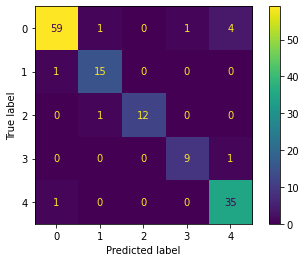

In [ ]:
disp_train_knn=ConfusionMatrixDisplay(train_knn_confusion)
disp_train_knn.plot()
plt.show()

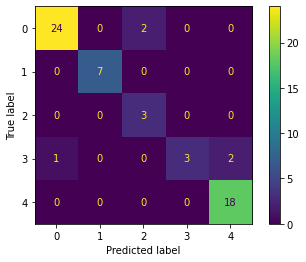

In [ ]:
disp_test_knn=ConfusionMatrixDisplay(test_knn_confusion)
disp_test_knn.plot()
plt.show()

In [ ]:
train_accurcy_score=accuracy_score(train_knn_pred,y_train)
test_accuracy_score=accuracy_score(test_knn_pred,y_test)
train_accurcy_score,test_accuracy_score

(0.9285714285714286, 0.9166666666666666)

In [ ]:
train_precision_score=precision_score(y_train,train_knn_pred,average='macro')
test_precision_score=precision_score(y_test,test_knn_pred,average='macro')
train_precision_score,test_precision_score

(0.9249132111861137, 0.892)

In [ ]:
train_precision_score=precision_score(y_train,train_knn_pred,average='weighted')
test_precision_score=precision_score(y_test,test_knn_pred,average='weighted')
train_precision_score,test_precision_score

(0.932046425127428, 0.9326666666666665)

In [ ]:
train_recall_score=recall_score(y_train,train_knn_pred,average='macro')
test_recall_score=recall_score(y_test,test_knn_pred,average='macro')
train_recall_score,test_recall_score

(0.9280982905982904, 0.8846153846153847)

In [ ]:
train_recall_score=recall_score(y_train,train_knn_pred,average='weighted')
test_recall_score=recall_score(y_test,test_knn_pred,average='weighted')
train_recall_score,test_recall_score

(0.9285714285714286, 0.9166666666666666)

### DecisionTree model

In [ ]:
train_dtree_pred=dtree.predict(X_train)
test_dtree_pred=dtree.predict(X_test)

In [ ]:
print(classification_report(y_train,train_dtree_pred))

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        65
       drugA       1.00      1.00      1.00        16
       drugB       1.00      1.00      1.00        13
       drugC       1.00      1.00      1.00        10
       drugX       1.00      1.00      1.00        36

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



In [ ]:
print(classification_report(y_test,test_dtree_pred))

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        26
       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



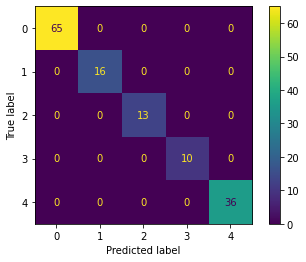

In [ ]:
train_dtree_confusion=confusion_matrix(y_train,train_dtree_pred)
disp_train_dtree=ConfusionMatrixDisplay(train_dtree_confusion)
disp_train_dtree.plot()
plt.show()

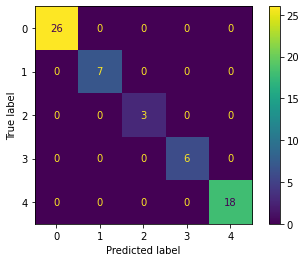

In [ ]:
test_dtree_confusion=confusion_matrix(y_test,test_dtree_pred)
disp_test_dtree=ConfusionMatrixDisplay(test_dtree_confusion)
disp_test_dtree.plot()
plt.show()

In [ ]:
dtree_train_accurcy_score=accuracy_score(train_dtree_pred,y_train)
dtree_test_accuracy_score=accuracy_score(test_dtree_pred,y_test)
dtree_train_accurcy_score,dtree_test_accuracy_score

(1.0, 1.0)

In [ ]:
dtree_train_precision_score=precision_score(train_dtree_pred,y_train,average='macro')
dtree_test_precision_score=precision_score(test_dtree_pred,y_test,average='macro')
dtree_train_precision_score,dtree_test_precision_score

(1.0, 1.0)

In [ ]:
dtree_train_precision_score=precision_score(train_dtree_pred,y_train,average='weighted')
dtree_test_precision_score=precision_score(test_dtree_pred,y_test,average='weighted')
dtree_train_precision_score,dtree_test_precision_score

(1.0, 1.0)

In [ ]:
dtree_train_recall_score=recall_score(train_dtree_pred,y_train,average='macro')
dtree_test_recall_score=recall_score(test_dtree_pred,y_test,average='macro')
dtree_train_recall_score,dtree_test_recall_score

(1.0, 1.0)

In [ ]:
dtree_train_recall_score=recall_score(train_dtree_pred,y_train,average='weighted')
dtree_test_recall_score=recall_score(test_dtree_pred,y_test,average='weighted')
dtree_train_recall_score,dtree_test_recall_score

(1.0, 1.0)

### Logestic Regression

In [ ]:
train_lgr_pred=lgr_model.predict(X_train)
test_lgr_pred=lgr_model.predict(X_test)

In [ ]:
print(classification_report(y_train,train_lgr_pred))

              precision    recall  f1-score   support

       DrugY       0.94      1.00      0.97        65
       drugA       0.55      1.00      0.71        16
       drugB       0.00      0.00      0.00        13
       drugC       0.00      0.00      0.00        10
       drugX       0.76      0.89      0.82        36

    accuracy                           0.81       140
   macro avg       0.45      0.58      0.50       140
weighted avg       0.70      0.81      0.74       140



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test,test_lgr_pred))

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        26
       drugA       0.70      1.00      0.82         7
       drugB       0.00      0.00      0.00         3
       drugC       0.00      0.00      0.00         6
       drugX       0.75      1.00      0.86        18

    accuracy                           0.85        60
   macro avg       0.49      0.60      0.54        60
weighted avg       0.74      0.85      0.79        60



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


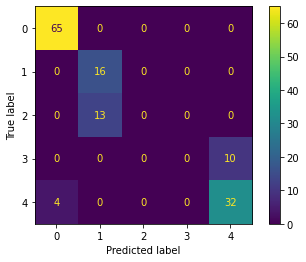

In [ ]:
train_lgr_confusion=confusion_matrix(y_train,train_lgr_pred)
disp_train_lgr=ConfusionMatrixDisplay(train_lgr_confusion)
disp_train_lgr.plot()
plt.show()

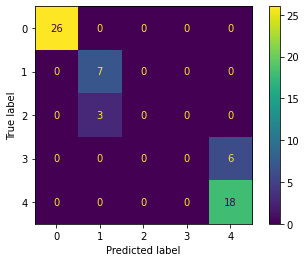

In [ ]:
test_lgr_confusion=confusion_matrix(y_test,test_lgr_pred)
disp_test_lgr=ConfusionMatrixDisplay(test_lgr_confusion)
disp_test_lgr.plot()
plt.show()

In [ ]:
lgr_train_accurcy_score=accuracy_score(train_lgr_pred,y_train)
lgr_test_accuracy_score=accuracy_score(test_lgr_pred,y_test)
lgr_train_accurcy_score,lgr_test_accuracy_score

(0.8071428571428572, 0.85)

In [ ]:
lgr_train_precision_score=precision_score(train_lgr_pred,y_train,average='macro')
lgr_test_precision_score=precision_score(test_lgr_pred,y_test,average='macro')
lgr_train_precision_score,lgr_test_precision_score

(0.5777777777777777, 0.6)

In [ ]:
lgr_train_precision_score=precision_score(train_lgr_pred,y_train,average='weighted')
lgr_test_precision_score=precision_score(test_lgr_pred,y_test,average='weighted')
lgr_train_precision_score,lgr_test_precision_score

(0.9666666666666666, 1.0)

In [ ]:
lgr_train_recall_score=recall_score(train_lgr_pred,y_train,average='macro')
lgr_test_recall_score=recall_score(test_lgr_pred,y_test,average='macro')
lgr_train_recall_score,lgr_test_recall_score

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4511315770686085, 0.49000000000000005)

In [ ]:
lgr_train_recall_score=recall_score(train_lgr_pred,y_train,average='weighted')
lgr_test_recall_score=recall_score(test_lgr_pred,y_test,average='weighted')
lgr_train_recall_score,lgr_test_recall_score

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8071428571428572, 0.85)

### Support Vector Machine (SVM)

In [ ]:
train_svc_pred=svm.predict(X_train)
test_svc_pred=svm.predict(X_test)

In [ ]:
print(classification_report(y_train,train_svc_pred))

              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        65
       drugA       0.94      1.00      0.97        16
       drugB       1.00      0.92      0.96        13
       drugC       1.00      1.00      1.00        10
       drugX       1.00      1.00      1.00        36

    accuracy                           0.99       140
   macro avg       0.99      0.98      0.99       140
weighted avg       0.99      0.99      0.99       140



In [ ]:
print(classification_report(y_test,test_svc_pred))

              precision    recall  f1-score   support

       DrugY       1.00      0.92      0.96        26
       drugA       1.00      1.00      1.00         7
       drugB       0.60      1.00      0.75         3
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00        18

    accuracy                           0.97        60
   macro avg       0.92      0.98      0.94        60
weighted avg       0.98      0.97      0.97        60



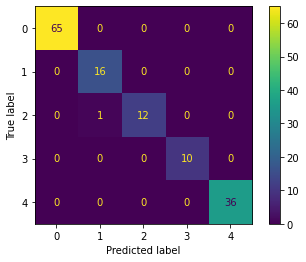

In [ ]:
train_svc_confusion=confusion_matrix(y_train,train_svc_pred)
disp_train_svc=ConfusionMatrixDisplay(train_svc_confusion)
disp_train_svc.plot()
plt.show()

In [ ]:
test_svc_confusion=confusion_matrix(y_test,test_svc_pred)
disp_test_svc=ConfusionMatrixDisplay(test_svc_confusion)
disp_test_svc.plot()
plt.show()

NameError: ignored

In [ ]:
svc_train_accurcy_score=accuracy_score(train_svc_pred,y_train)
svc_test_accuracy_score=accuracy_score(test_svc_pred,y_test)
svc_train_accurcy_score,svc_test_accuracy_score

(0.9928571428571429, 0.9666666666666667)

In [ ]:
svc_train_precision_score=precision_score(train_svc_pred,y_train,average='macro')
svc_test_precision_score=precision_score(test_svc_pred,y_test,average='macro')
svc_train_precision_score,svc_test_precision_score

(0.9846153846153847, 0.9846153846153847)

In [ ]:
svc_train_precision_score=precision_score(train_svc_pred,y_train,average='weighted')
svc_test_precision_score=precision_score(test_svc_pred,y_test,average='weighted')
svc_train_precision_score,svc_test_precision_score

(0.9934065934065935, 0.9692307692307692)

In [ ]:
svc_train_recall_score=recall_score(train_svc_pred,y_train,average='macro')
svc_test_recall_score=recall_score(test_svc_pred,y_test,average='macro')
svc_train_recall_score,svc_test_recall_score

(0.9882352941176471, 0.9199999999999999)

In [ ]:
svc_train_recall_score=recall_score(train_svc_pred,y_train,average='weighted')
svc_test_recall_score=recall_score(test_svc_pred,y_test,average='weighted')
svc_train_recall_score,svc_test_recall_score

(0.9928571428571429, 0.9666666666666667)

In [ ]:
pd.DataFrame({'model':['KNN','LGR','SVM','Dtree'],
              'train_score':[train_recall_score,lgr_train_recall_score,svc_train_recall_score,dtree_train_recall_score],
              'test_score':[test_recall_score,lgr_test_recall_score,svc_test_recall_score,dtree_test_recall_score],
              'average_fit_time':['2.81 sec','4.13 sec','43.3 ms',' 19.5 sec']})

,model,train_score,test_score,average_fit_time
0,KNN,0.928571,0.916667,2.81 sec
1,LGR,0.807143,0.850000,4.13 sec
2,SVM,0.992857,0.966667,43.3 ms
3,Dtree,1.000000,1.000000,19.5 sec


### Additional method a kernel based logestic regression

In [ ]:
drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [ ]:
sex_dummy=pd.get_dummies(drug['Sex'])
BP_dummy=pd.get_dummies(drug['BP'])
CHl_dummy=pd.get_dummies(drug['Cholesterol'])


In [ ]:
drug_and_dummies=pd.concat([drug,sex_dummy,BP_dummy,CHl_dummy],axis=1)
drug_and_dummies.drop(['Sex','BP','Cholesterol'],axis=1, inplace=True)


In [ ]:
drug_and_dummies.head()

,Age,Na_to_K,Drug,F,M,HIGH,LOW,NORMAL,HIGH,NORMAL
0,23,25.355,DrugY,1,0,1,0,0,1,0
1,47,13.093,drugC,0,1,0,1,0,1,0
2,47,10.114,drugC,0,1,0,1,0,1,0
3,28,7.798,drugX,1,0,0,0,1,1,0
4,61,18.043,DrugY,1,0,0,1,0,1,0


In [ ]:
X=drug_and_dummies.drop('Drug', axis=1)
y=drug_and_dummies['Drug']

In [ ]:
X.shape

(200, 9)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler=StandardScaler()
scaled_train_data=scaler.fit_transform(X_train)
scaled_test_data=scaler.transform(X_test)


In [ ]:
xtrain=polynomial_kernel(scaled_train_data,scaled_train_data,degree=2)
xtest=polynomial_kernel(scaled_test_data,scaled_test_data,degree=2)

logestic=LogisticRegression(max_iter=10000).fit(xtrain,y_train)

In [ ]:
train_score=logestic.score(xtrain,y_train)
train_score

1.0

In [ ]:
scale_df=pd.DataFrame(scaled_train_data)
rbf=rbf_kernel(scaled_train_data,scaled_train_data)
rbf_lgr=LogisticRegression(max_iter=10000).fit(rbf,y_train)

In [ ]:
rbf_train_score=rbf_lgr.score(rbf,y_train)
rbf_train_score

0.9857142857142858

### From scratch 

Kernelized Logestic regression model

In [ ]:
def Kernel_matrix(kfunc, X):
    N, _ = X.shape
    K = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = kfunc(X[i, :], X[j, :])
    return K

In [ ]:
def evaluate_kernel_model(model, kfunc, X_train, X_test):
    N1, _ = X_train.shape
    N2, _ = X_test.shape
    
    K = np.empty((N2, N1))
    for i in range(N2):
        for j in range(N1):
            K[i, j] = kfunc(X_train[j, :], X_test[i, :])
    return model.predict(K)

In [ ]:
def kernel_function(x, z):
    return (np.dot(x, z) + 1) ** 2

In [ ]:
kernel_matrix = Kernel_matrix(kernel_function, scaled_train_data)
logistic = LogisticRegression(max_iter=10000).fit(kernel_matrix, y_train)

In [ ]:
predictions = evaluate_kernel_model(logistic, kernel_function, scaled_train_data, scaled_test_data)

In [ ]:
accuracy_score(predictions,y_test)

0.95